# Fractional Pixel Extraction

## Description

As the name suggest _fractional pixel extraction_ is a step up in complexity when compared to a _simple extraction_. _Simple extraction_ meaning that the sum of flux is perfomed using integer pixel values.

I will choose a 400 l/mm grating in order to get a larger misalignement of the spectrum.

In [251]:
# append goodman's path to be able to import
import sys
sys.path.append('/user/simon/development/soar/goodman')

# import goodman
from goodman.pipeline.core import identify_targets, trace
# from goodman.goodman.core import identify_targets

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


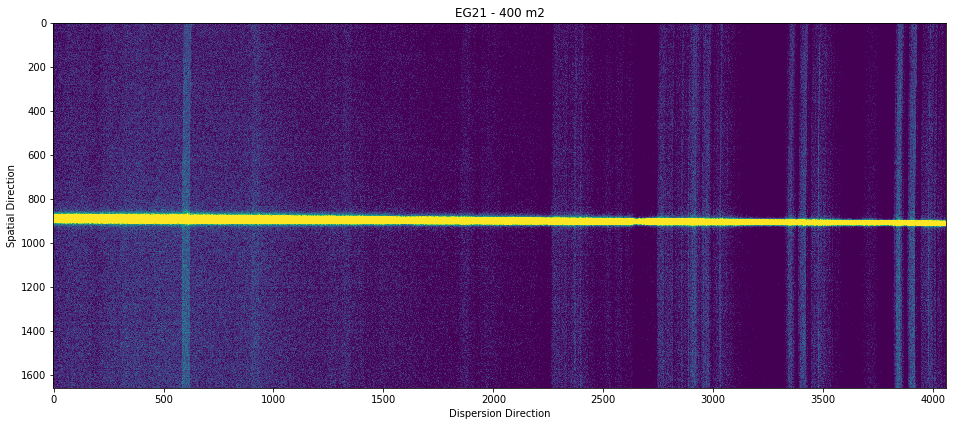

In [252]:
from ccdproc import CCDData
from astropy import units as u
import matplotlib.pyplot as plt

sample_file = 'fits/cfzsto_0199_EG21_400M2_GG455.fits'

ccd = CCDData.read(sample_file, unit=u.adu)

title = "{:s} - {:s}".format(ccd.header['OBJECT'],
                             ccd.header['WAVMODE'])

fig, ax = plt.subplots(figsize=(16,10))
plt.imshow(ccd.data, clim=(20, 100))
ax.set_title(title)
ax.set_xlabel("Dispersion Direction")
ax.set_ylabel("Spatial Direction")
plt.show()


## Necessary Preamble

The method I'm trying to develop here is focused on the extraction only, therefore we need to use the already built functions of the Goodman Pipeline in order to identify and trace the target.

### Target Identify
It returns a Gaussian1D model or a sum of them. If it encounters more than one.
The function is named `identify_targets` and uses a CCDData object as input. By default the maximum number of targets that it will try to detect is 3 `nfind=3` but it can be set to any value. We will set it to 1.

In [253]:
target = identify_targets(ccd=ccd, nfind=1)

Here, `target` is an `astropy.modeling.models.Gaussian1D` instance. Below you can see its parameters.

In [254]:
print(target)

Model: Gaussian1D
Name: Gaussian_898
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
      amplitude    mean     stddev   
    ------------- ----- -------------
    1198.77636719 898.0 6.86701963418


### Target Trace

The trace is also already developed as part of the Goodman pipeline. `goodman.pipeline.core.trace`.

In order to call this function a set of objects need to be parsed.
- `ccd`: is an instance of ccdproc.CCDData
- `model`: Is the output from `identify_targets`. (a Gaussian fitted to the spatial profile)
- `trace_model`: is an instance of `astropy.modeling.models.Polynomial1D`. Usually a low order polynomial although it can be any model that makes sense for a trace.
- `fitter`: Is fitter method in this case an instance of `astropy.modeling.fitting.LevMarLSQFitter`.
- `sampling_steps`: the size of the step in pixels used to sample the trace. A sample step of one would mean a fit is performed for each dispersion column.

In [255]:
from astropy.modeling import models, fitting

# this is sort of a blank model that will be used to fit the trace once the data is sampled.
# .. The fitted version of this will be returned.
trace_model  = models.Polynomial1D(degree=2)
trace_fitter = fitting.LevMarLSQFitter()

target_trace = trace(ccd=ccd, model=target,trace_model=trace_model,fitter=trace_fitter,sampling_step=5)

Again it will return an `astropy.modeling.model.Model` instance (which is the base class for `Polynomial1D` and others included `Gaussian1D`.

Below all the parameters are printed.

In [256]:
print(target_trace)

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
          c0             c1                c2        
    ------------- ---------------- ------------------
    890.662649773 0.00521742880821 -1.85661790183e-08


The `target_trace` object is a callable which is equivalent to

$$f(x) = c0 + c1 *x + c2 * x ^ 2$$

and therefore if you call it with an array as argument will return the full array of the trace.

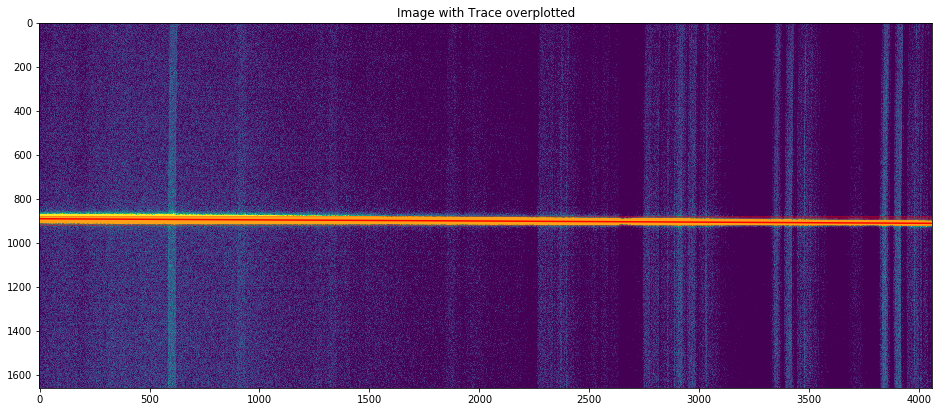

In [257]:
# create an array with the dispersion axis and the trace array
spatial_size, dispersion_size = ccd.data.shape
dispersion_axis = range(dispersion_size)
trace_array = target_trace(dispersion_axis)

t_stddev = target.stddev.value
t_mean = target.mean.value

n_sigmas = 3
low_limit = t_mean - n_sigmas * t_stddev
high_limit = t_mean + n_sigmas * t_stddev




fig, ax = plt.subplots(figsize=(16,10))
ax.imshow(ccd.data, clim=(20, 100))
ax.plot(dispersion_axis, trace_array, color='r')
ax.axhspan(low_limit, high_limit, color='red', alpha=.3)
ax.set_title("Image with Trace overplotted")
plt.show()

### The trace itself.

The `target_trace` object, the model, is what I intend to use to find obtain the extraction. First I should get the extraction using the current implementation, which we know is not perfect, and then compare with the new method I will develop.

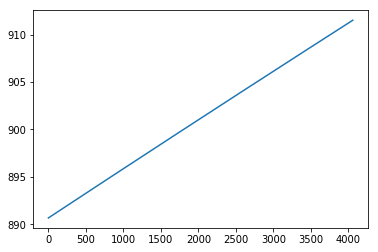

In [258]:
plt.plot(dispersion_axis, trace_array)
plt.show()

## Fractional Pixel Extraction

Let's define a function `fractional_extraction`

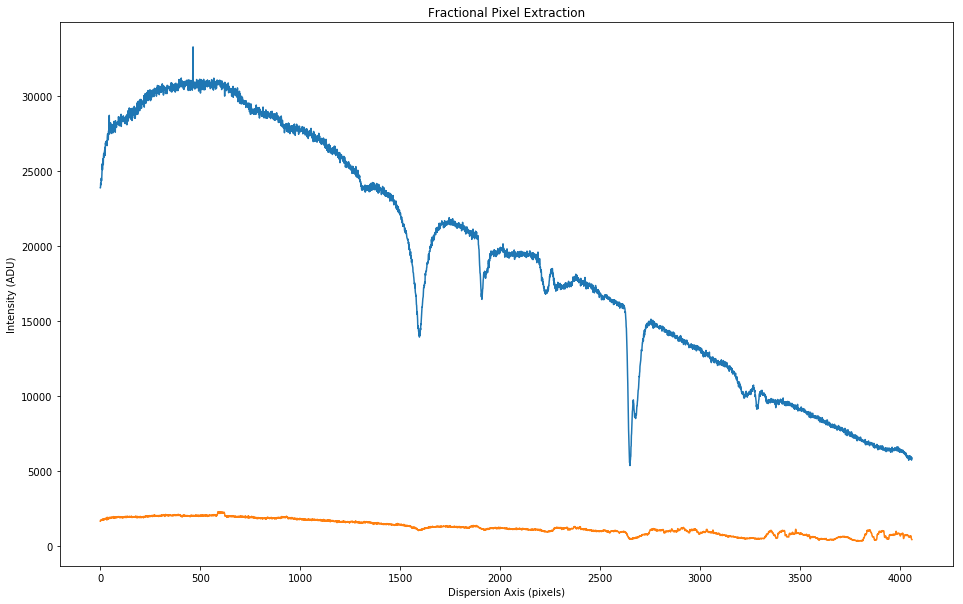

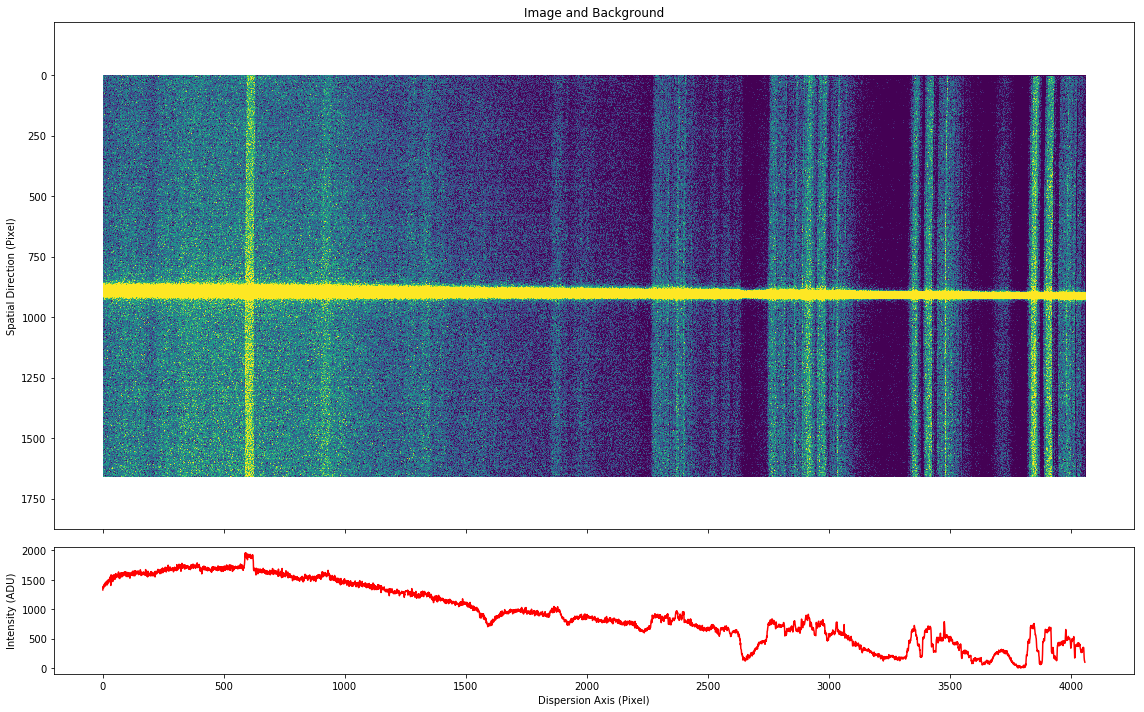

In [259]:
from astropy.modeling import Model
from math import floor, ceil
import numpy as np

def fractional_sum(data, index, low_limit, high_limit):
    """Performs a fractional pixels sum
    
    A fractional pixels sum is requiered several times while
    extracting a 1D spectrum from a 2D spectrum. The method
    is actually very simple.
    
    It requieres the full data, the colum and the range to sum, this
    range is given as real numbers. First it identify the extreme
    pixels that are going to be summed complete, i.e. no fraction.
    Then it will identify the index of the last pixel to each side,
    the ones that contribute with only a fraction to the sum
    and it also calculates the fraction that will be summed.
    
    The sum is performed in one operation. It does not do 
    background subtraction, for which this very same method is used to
    get the background sum to be subtracted later.
    
    Args:
        data (numpy.ndarray): 2D array that contains the 2D spectrum/image
        index (int): Index of the colum to be summed.
        low_limit (float): Lower limit for the range to be summed.
        high_limit (float): Higher limit for the range to be summed.
        
    Returns:
        Sum in ADU of all pixels and fractions between `low_limit` and `high_limit`.
    """
    # these are the limits whithin the full amount of flux on each pixel is summed
    low_limit_last_full = ceil(low_limit)
    high_limit_last_full = floor(high_limit)
        
    # Very last pixel 
    low_last_index = floor(low_limit)
    high_last_index = ceil(high_limit)
    
    # Multiplying factor for the last "fractional pixel"
    low_last_factor = low_limit_last_full - low_limit
    high_last_factor = high_limit - high_limit_last_full
    
    # target's sum
    column_sum = np.sum(data[low_limit_last_full:high_limit_last_full, index]) + \
        data[low_last_index, index] * low_last_factor + \
        data[high_last_index, index] * high_last_factor
    
    return column_sum

def fractional_extraction(ccd, target_trace, target_stddev, extraction_width):
    """Performs an spectrum extraction using fractional pixels.
    
    Args:
        ccd (object): Image containing a 2D spectrum. Instance of CCDData.
        target_trace (object):  Instance of astropy.modeling.models.Model.
        extraction_width (int): Width of the extraction area in units of
          `target_stddev`.
    """
    assert isinstance(ccd, CCDData)
    assert isinstance(target_trace, Model)
    
    spat_length, disp_length = ccd.data.shape
    
    disp_axis = range(disp_length)
    trace = target_trace(disp_axis)
    
    extracted_spectrum = []
    background_list = []
    for i in disp_axis:

        # this defines the extraction limit for every column 
        low_limit = trace[i] - 0.5 * extraction_width * target_stddev
        high_limit = trace[i] + 0.5 * extraction_width * target_stddev
        
        column_sum = fractional_sum(data=ccd.data, index=i, low_limit=low_limit, high_limit=high_limit)
            
        # background limits
        
        # background_spacing is the distance from the edge of the target's limits defined by `int_low_limit` and 
        # `int_high_limit` in stddev units
        background_spacing = 0.5
        background_width = high_limit - low_limit
        
        # define pixel values for background subtraction
        # low_background_zone
        high_1 = low_limit - background_spacing * target_stddev
        low_1 = high_1 - background_width
        # print(low_1,high_1)
        
        # High background zone
        low_2 = high_limit + background_spacing * target_stddev
        high_2 = low_2 + background_width
        # print(low_1,'-',high_1,':',low_2,'-',high_2,)
        
        # validate background subtraction zones
        background_1 = None
        background_2 = None
        
        #this has to be implemented
        neighbouring_target_condition = True
        
        if low_1 > 0 and neighbouring_target_condition:
            # integer limits
            background_1 = fractional_sum(data=ccd.data, index=i, low_limit=low_1, high_limit=high_1)
        else:
            print("Invalid Zone 1")
            
        if high_2 < spat_length and neighbouring_target_condition:
            background_2 = fractional_sum(data=ccd.data, index=i, low_limit=low_2, high_limit=high_2)
        else:
            print("Invalid Zone 2")
        
        background = 0
        if background_1 is not None and background_2 is None:
            background = background_1
        elif background_1 is None and background_2 is not None:
            background = background_2
        else:
            background = np.mean([background_1, background_2])
        
        # actual background subtraction
        background_subtracted_column_sum = column_sum - background 
        
        # append column value to list
        extracted_spectrum.append(background_subtracted_column_sum)
        background_list.append(background)
        
    new_ccd = ccd.copy()
    new_ccd.data = np.asarray(extracted_spectrum)
    return new_ccd, np.asarray(background_list)

spectrum, background = fractional_extraction(ccd=ccd,
                                             target_trace=target_trace,
                                             target_stddev=target.stddev.value,
                                             extraction_width=n_sigmas)

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(spectrum.data)
ax.plot(background)
ax.set_title("Fractional Pixel Extraction")
ax.set_xlabel("Dispersion Axis (pixels)")
ax.set_ylabel("Intensity (ADU)")
plt.show()

fig2, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

ax1.set_title("Image and Background")
ax1.imshow(ccd.data, clim=(15, 50))
ax1.set_ylabel("Spatial Direction (Pixel)")
ax2.set_ylabel("Intensity (ADU)")
ax2.set_xlabel("Dispersion Axis (Pixel)")
ax2.plot(background - np.min(background), color='r')
# plt.ylim(0, 1800)
plt.tight_layout()
plt.show()


# Pipeline Extraction

The Goodman Spectroscopic Pipeline has the `spectroscopic_extraction` function that performs the extraction from 2D to 1D. The extraction method `simple` means it will capture a rectangular region and then will do a crude sum across the spatial direction.

In [260]:
from goodman.pipeline.core import spectroscopic_extraction
    
extracted, comps = spectroscopic_extraction(
                        ccd=ccd,
                        extraction='simple',
                        nfind=1,
                        n_sigma_extract=n_sigmas,
                        plots=False)

# plt.plot(extracted[0].data)
# plt.show()

# print(extracted)

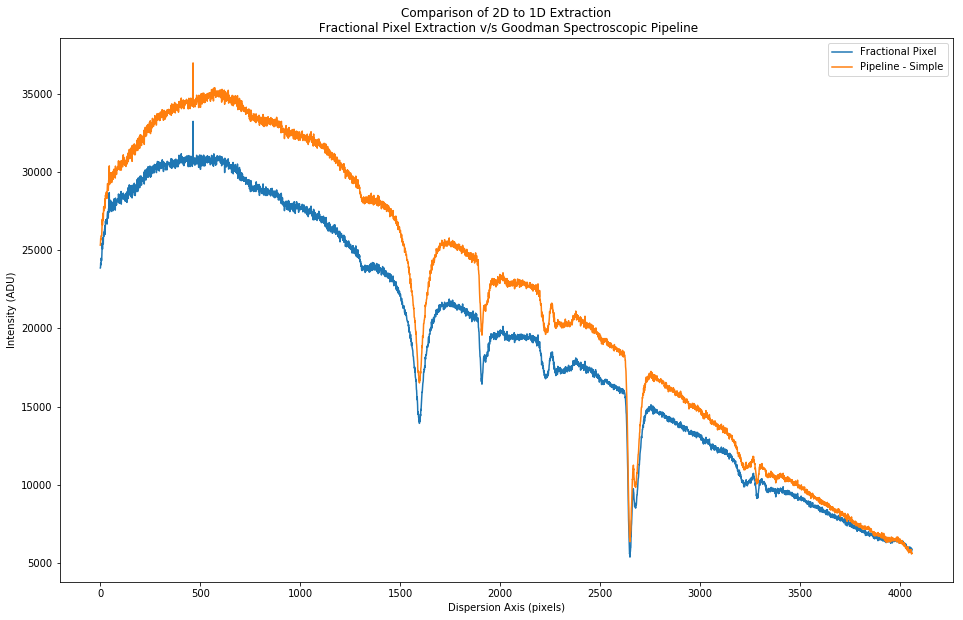

In [261]:
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(spectrum.data, label="Fractional Pixel")
ax.plot(extracted[0].data, label="Pipeline - Simple")
plt.legend(loc='best')
ax.set_title("Comparison of 2D to 1D Extraction\n Fractional Pixel Extraction v/s Goodman Spectroscopic Pipeline")
ax.set_xlabel("Dispersion Axis (pixels)")
ax.set_ylabel("Intensity (ADU)")
plt.show()

# New Simple Extraction

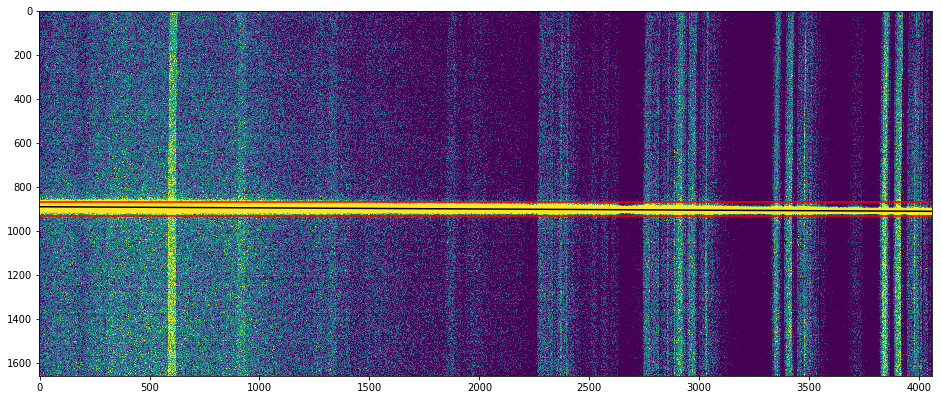

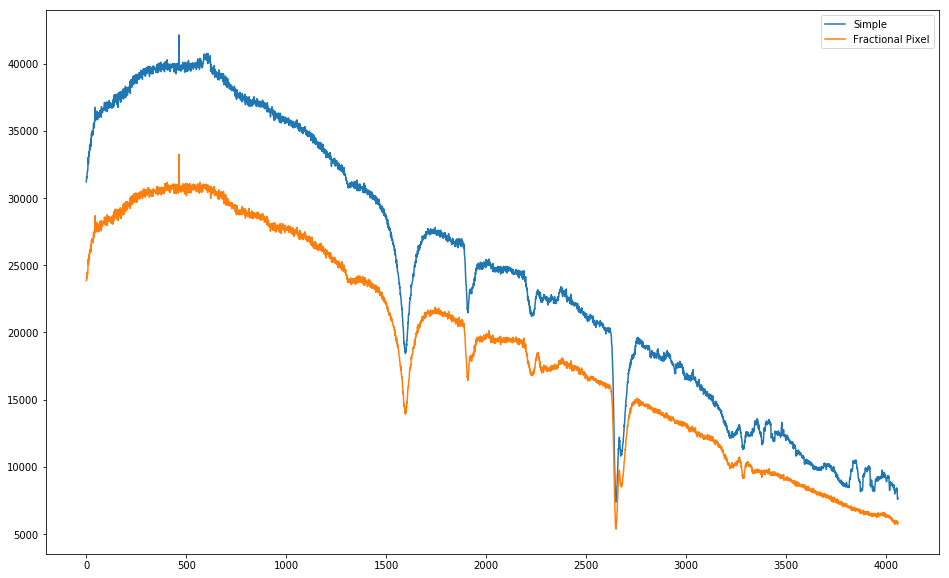

In [263]:
def extract_simple(ccd, target_trace, target_stddev, extraction_width,
                   background_spacing=0.5):
    assert isinstance(ccd, CCDData)
    assert isinstance(target_trace, Model)
    
    spat_length, disp_length = ccd.data.shape
    
    # create an array with the trace
    trace_points = target_trace(range(disp_length))
    
    # find the extreme values
    trace_min = np.min(trace_points)
    trace_max = np.max(trace_points)
    
    low_limit = floor(trace_min - 0.5 * extraction_width * target_stddev)
    high_limit = floor(trace_max + 0.5 * extraction_width * target_stddev)
    
    simple_extracted = np.sum(ccd.data[low_limit:high_limit, :], axis=0)
    
    plt.figure(figsize=(16,10))
    plt.imshow(ccd.data, clim=(20,50))
    plt.plot(trace_points, color='k')
    plt.axhline(low_limit, color='r')
    plt.axhline(high_limit, color='r')
    plt.show()
    
    plt.figure(figsize=(16,10))
    plt.plot(simple_extracted, label='Simple')
    plt.plot(spectrum.data, label="Fractional Pixel")
    plt.legend(loc='best')
    plt.show()

extract_simple(ccd=ccd, target_trace=target_trace, target_stddev=target.stddev.value, extraction_width=6)

# Experiment

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
1538 4060
Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
         c0              c1                c2       
    ------------ ----------------- -----------------
    786.45440967 -0.00497729892796 1.27611659091e-07


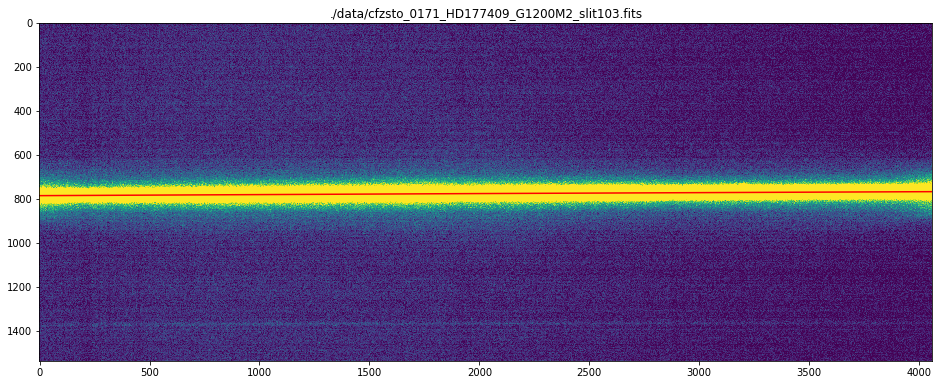

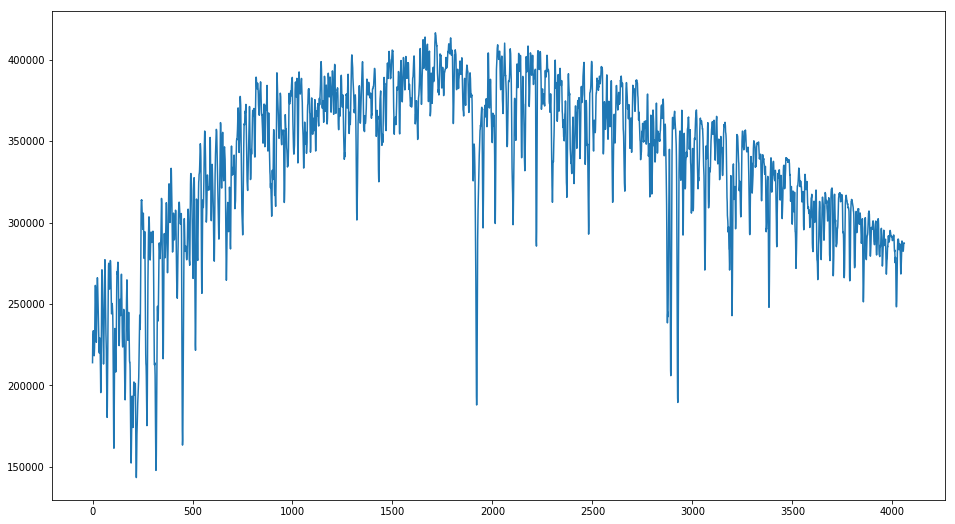

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
1537 4060
Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
          c0              c1                c2        
    ------------- ----------------- ------------------
    788.317963152 -0.00367751912956 -6.46205167351e-08


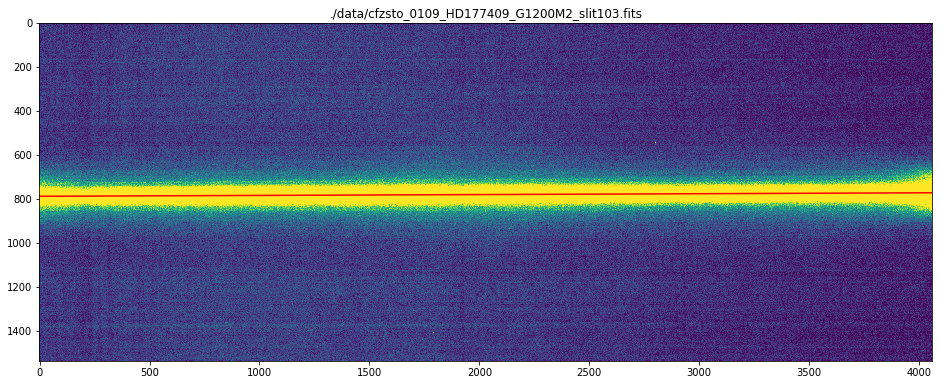

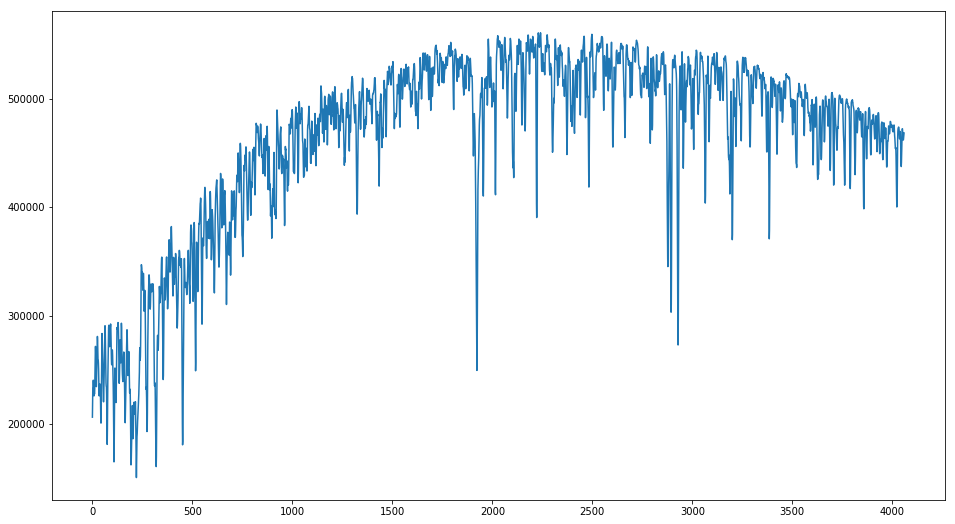

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
1537 4060
Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
          c0              c1                c2        
    ------------- ----------------- ------------------
    800.987142731 -0.00303007390316 -1.80327901544e-07


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


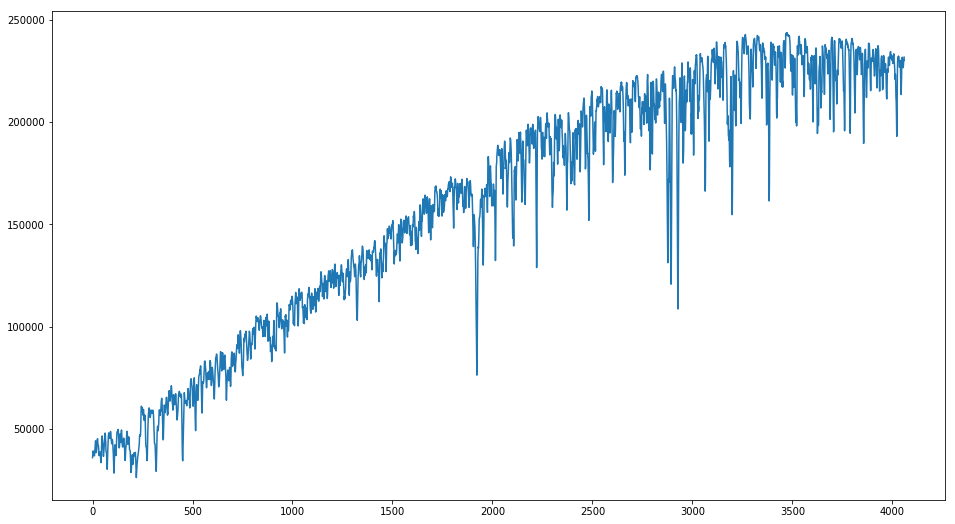

In [292]:
-